Gravitino dark matter and lepton cosmic ray data with `python`
=========================

## Install

### What?
`python` es un lenguaje de programacion ampliamente usado en ciencia y analisis de datos. Sus caracteristicas son una sintaxis limpia y versatil ademas de numerosas y variadas librerias que son continuamente soportadas. La instalacion de `python` es muy sencilla ya que viene contenido en la distribucion de [Anaconda](https://www.anaconda.com/download/).

### Where?
Ademas de un lenguaje de programacion necesitamos un ambiente amigable para programar. El archivo en el que este documento esta escrito se llama [Jypyter Notebook](https://www.dataquest.io/blog/jupyter-notebook-tutorial/) (incluido en anaconda). Un `notebook` esta compuesto de 'celdas' quye pueden ser de texto [Markdown](https://help.github.com/articles/basic-writing-and-formatting-syntax/) o codigo que pueden ser ejecutadas individualmente. Una herramienta extremadamente util de los notebooks es la tab-completacion. Cuando escribimos parcialmente el nombre de una variable o funcion que exista dentro del notebook y presionamos la tecla `TAB` la instruccion se escribe automaticamente (o recibimos opciones para completarla)

### Extender?
Ahora que tenemos con que trabajar podemos aumentar la potencia de nuestro programa. `python` empieza a trabajar inicialmente con numero limitado de funcionalidades: manejo de variables, entrada y salida de informacion entre otros. Las funciones ya programadas se encuentran en librerias, por ejemplo la libreria `numpy` contiene las funciones de analisis numerico. La instruccion para agregar un **metodo** de una **libreria** y darle un **apodo** es
```
from libreria import metodo as apodo
```

No todas las librerias vienen incluidas en Anaconda, para instalar una **libreria** nueva usamos la siguiente instruccion (ojo con el signo de excamacion !)

```
! pip install libreria
```
**Ejemplo** descargar e instalar la ultima version de `seaborn 0.9.0`

In [7]:
! pip install --upgrade pip
! pip install seaborn==0.9.0

Requirement already up-to-date: pip in /anaconda3/lib/python3.6/site-packages (18.1)


Some required libraries

In [13]:
import json # JSON (JavaScript Object Notation) is a lightweight data-interchange format. It is easy for humans to read and write. It is easy for machines to parse and generate.
import pymultinest # all the magic is here, take a look to the Johannes page https://johannesbuchner.github.io/PyMultiNest/
import matplotlib.pyplot as plt # Library for graphics
import numpy as np # Library for scientific computation
import pandas as pd # Python Data Analysis Library https://pandas.pydata.org
import seaborn as sb #  Python data visualization library based on matplotlib https://seaborn.pydata.org

Finally, we tune some options to improve the visualization of the outputs

In [46]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

%matplotlib inline

sb.set_context('notebook')
sb.set_palette('deep')

In [47]:
nthreads = 2

## Import data

ep_data:          e+/(e-+e+) from Accardo et al., PRL 113, 121101 (2014)

e_data:           e- from Accardo et al., P2014PhRvL.113l1102A

p_data:           e+ from Accardo et al., P2014PhRvL.113l1102A

epp_dampe_data:   (e- + e+) from DAMPE

epp_AMS02_data:   (e- + e+) from AMS02

epp_CALET_data:   (e- + e+) from CALET


In [48]:
ep_data = np.genfromtxt('electron_positron_fraction_AMS02_usine.dat',usecols=(3,4,5,6,7,8,9,10),
                     dtype=[('Ener', float),
                            ('EBIN_LOW', float),
                            ('EBIN_HIGH', float),
                            ('VALUE', float),
                            ('ERR_STATme', float),
                            ('ERR_STATma', float),
                            ('ERR_SYSTme', float),
                            ('ERR_SYSTma', float),]) # e+/(e-+e+) from Accardo et al., PRL 113, 121101 (2014)

e_data = np.genfromtxt('flux_electron_AMS02.dat',usecols=(3,4,5,6,7,8,9,10),
                     dtype=[('Ener', float),
                            ('EBIN_LOW', float),
                            ('EBIN_HIGH', float),
                            ('VALUE', float),
                            ('ERR_STATme', float),
                            ('ERR_STATma', float),
                            ('ERR_SYSTme', float),
                            ('ERR_SYSTma', float),]) # e- from Accardo et al., P2014PhRvL.113l1102A

p_data = np.genfromtxt('flux_positrons_AMS02.dat',usecols=(3,4,5,6,7,8,9,10),
                     dtype=[('Ener', float),
                            ('EBIN_LOW', float),
                            ('EBIN_HIGH', float),
                            ('VALUE', float),
                            ('ERR_STATme', float),
                            ('ERR_STATma', float),
                            ('ERR_SYSTme', float),
                            ('ERR_SYSTma', float),]) # e- from Accardo et al., P2014PhRvL.113l1102A


epp_dampe_data = np.genfromtxt('electron_positron_sum_DAMPE_China.dat',usecols=(2,0,1,9,10),
                     dtype=[('Ener', float),
                            ('EBIN_LOW', float),
                            ('EBIN_HIGH', float),
                            ('VALUE', float),
                            ('ERR_STATma', float),]) # (e-+e+) from DAMPE

epp_AMS02_data = np.genfromtxt('flux_electronANDpositrons_AMS02.dat',usecols=(3,4,5,6,7,8,9,10),
                     dtype=[('Ener', float),
                            ('EBIN_LOW', float),
                            ('EBIN_HIGH', float),
                            ('VALUE', float),
                            ('ERR_STATme', float),
                            ('ERR_STATma', float),
                            ('ERR_SYSTme', float),
                            ('ERR_SYSTma', float),]) # 


epp_CALET_data = np.genfromtxt('electron_positron_sum_CALET.dat',usecols=(2,0,1,3,4),
                     dtype=[('Ener', float),
                            ('EBIN_LOW', float),
                            ('EBIN_HIGH', float),
                            ('VALUE', float),
                            ('ERR_STATma', float),]) # e- from Accardo et al., P2014PhRvL.113l1102A


x = p_data['Ener']

In [49]:
x = p_data['Ener'] # We define the energy dimension as the energy bins from the positron dataset.

### Definition of priors

A more elaborate prior. parameters are pos1, width, height1, [height2]

In [50]:
def prior(cube, ndim, nparams):
        cube[0] = cube[0]*40            # Cp uniform prior between 0:40
        cube[1] = cube[1]*5            # gammap uniform prior between 0:5
        cube[2] = cube[2]*600-100            # Ce uniform prior between 0:400
        cube[3] = cube[3]*5            # gammae uniform prior between 0:5
        cube[4] = cube[4]*10            # Cs uniform prior between 0:5
        cube[5] = cube[5]*4            # gammas uniform prior between 0:3
        cube[6] = 10**(cube[6]*(4) - 6) # Esi log-uniform prior between 10^-4 and 1
        cube[7] = (cube[7]*(4) - 4) # g log-uniform prior between 10^-4 and 1
        cube[8] = (cube[8]*(4) - 4) # h log-uniform prior between 10^-4 and 1
        cube[9] = (cube[9]*(4) - 4) # i log-uniform prior between 10^-4 and 1
        cube[10] = (cube[10]*(4) - 4) # j log-uniform prior between 10^-4 and 1

### Definition of the functions to compute the models as function of energy (x)

In [51]:
def fraction(Ce,gammae,Cp,gammap,Cs,gammas,Esi):
    def spectrum(x):
        return Cp*(x**(-gammap)) + Cs*(x**(-gammas))*np.exp(-x*Esi) / ( Cp*(x**(-gammap)) + Cs*(x**(-gammas))*np.exp(-x*Esi) + Ce*(x**(-gammae)) + Cs*(x**(-gammas))*np.exp(-x*Esi) )
#        return positrons(Ce,gammae,Cp, gammap, Cs, gammas, Esi) / ( positrons(Ce,gammae,Cp, gammap, Cs, gammas, Esi) + electrons(Ce, gammae,Cp, gammap, Cs, gammas, Esi) )
    return spectrum(ep_data['Ener'])

def suma(Ce,gammae,Cp,gammap,Cs,gammas,Esi):
    def spectrum(x):
        return  ( Cp*(x**(-gammap)) + Ce*(x**(-gammae)) + 2*Cs*(x**(-gammas))*np.exp(-x*Esi) )
#        return positrons(Ce,gammae,Cp, gammap, Cs, gammas, Esi) / ( positrons(Ce,gammae,Cp, gammap, Cs, gammas, Esi) + electrons(Ce, gammae,Cp, gammap, Cs, gammas, Esi) )
    return spectrum(epp_dampe_data['Ener'])

def positrons(Cp,gammap,Cs,gammas,Esi):
    def spectrum(x):
        return  Cp*(x**(-gammap)) + Cs*(x**(-gammas))*np.exp(-x*Esi)
    return spectrum(p_data['Ener'])


def electrons(Ce,gammae,Cs,gammas,Esi):
    def spectrum(x):
        return  Ce*(x**(-gammae)) + Cs*(x**(-gammas))*np.exp(-x*Esi)
    return spectrum(e_data['Ener'])


def sour(Cs, gammas, Esi, x):
    model2 =  Cs*(x**(-gammas))*np.exp(-x*Esi)
    return model2

def back(Cp, gammap, x):
    model = Cp * (x**(-gammap))
    return model


### Definition of the logLikelihood

This is the function that compares data with models. We include a systematic error proportional to the model

In [52]:
def loglike(cube,ndim,nparams):
        Cp, gammap,Ce, gammae, Cs, gammas, Esi, logg, logh, logi, logj =cube[0], cube[1], cube[2], cube[3], cube[4],cube[5], cube[6], cube[7], cube[8], cube[9], cube[10]
        g = 10**logg
        h = 10**logh
        i = 10**logi
        j = 10**logj
        ymodelp = positrons(Cp,gammap,Cs,gammas, Esi)
        yerrp = p_data['ERR_STATma']
        yp = p_data['VALUE']
        inv_sigma2p = 1.0/(yerrp**2 + ymodelp**2*np.exp(2)*g)
        loglikep = -0.5*(np.sum((yp-ymodelp)**2*inv_sigma2p - np.log(inv_sigma2p)))
        ymodele = electrons(Ce,gammae,Cs,gammas, Esi)
        yerre = e_data['ERR_STATma']
        ye = e_data['VALUE']
        inv_sigma2e = 1.0/(yerre**2 + ymodele**2*np.exp(2)*h)
        loglikee = -0.5*(np.sum((ye-ymodele)**2*inv_sigma2e - np.log(inv_sigma2e)))
        ymodelep = fraction(Cp,gammap,Ce,gammae,Cs,gammas, Esi)
        yerrep = ep_data['ERR_STATma']
        yep = ep_data['VALUE']
        inv_sigma2ep = 1.0/(yerrep**2 + ymodelep**2*np.exp(2)*i)
        loglikeep = -0.5*(np.sum((yep-ymodelep)**2*inv_sigma2ep - np.log(inv_sigma2ep)))
        ymodeleppc = suma(Cp,gammap,Ce,gammae,Cs,gammas, Esi)
        yerreppc = epp_dampe_data['ERR_STATma']
        yeppc = epp_dampe_data['VALUE']
        inv_sigma2eppc = 1.0/(yerreppc**2 + ymodeleppc**2*np.exp(2)*j)
        loglikeeppc = -0.5*(np.sum((yeppc-ymodeleppc)**2*inv_sigma2eppc - np.log(inv_sigma2eppc)))
        return loglikep + loglikee + loglikeep + loglikeeppc


### Define the electron and positron data to use, root name for the output and the parameters to fit

In [53]:
ypdata = p_data['VALUE']
yedata = e_data['VALUE']
datafile = "all_multines_B_test_DAMPE_jupyter"
parameters = ["Cp", "gammap", "Ce", "gammae", "Cs", "gammas", "Esi", "g", "h", "i","j"]
n_params = len(parameters)

## Run MultiNest

In [54]:
pymultinest.run(loglike, prior, n_params, outputfiles_basename=datafile + '_1_', resume = False, verbose = True)
json.dump(parameters, open(datafile + '_1_params.json', 'w')) # save parameter names

## Analize MultiNest output

plot the distribution of a posteriori possible models

<Container object of 3 artists>

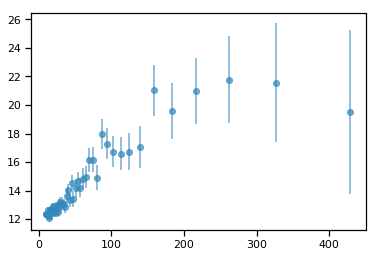

In [35]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

Cp_true =  28.1 #18.0#26.9
gammap_true = 3.666#3.5#3.79

Cs_true = 2.57#3.0# 4.21
gammas_true = 2.591#2.647#2.707
Esi_true = 0.00082#2.4e-4#1.5e-4

#f_true = 0.001
g_true = 2.15e-2#1e-5#1.85e-2

#plt.plot(x, ydata, '+ ', color='red', label='data')
plt.errorbar(p_data['Ener'], (p_data['Ener']**3)*p_data['VALUE'], yerr=(p_data['Ener']**3)*p_data['ERR_STATma'],color='#3288bd',label='positrons', fmt='o',alpha=0.7)

  analysing data from all_multines_B_test_DAMPE_jupyter_1_.txt


(5, 30)

(5, 1000.0)

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.]),
 <a list of 7 Text xticklabel objects>)

(array([ 5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. , 27.5]),
 <a list of 10 Text yticklabel objects>)

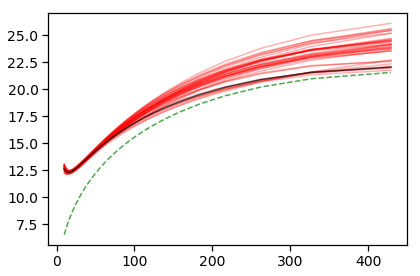

In [40]:
a = pymultinest.Analyzer(outputfiles_basename=datafile + '_1_', n_params = n_params)
for (Cp, gammap, Ce, gammae, Cs, gammas, Esi, logg, h, i, j) in a.get_equal_weighted_posterior()[::100,:-1]:
    plt.plot(p_data['Ener'], (p_data['Ener']**3)*positrons(Cp, gammap, Cs, gammas, Esi),color='red',alpha=0.3)
#        plt.plot(p_data['Ener'], (p_data['Ener']**3)*sour(Cs, gammas, Esi,p_data['Ener']),color='blue',ls='--', alpha=0.2)
#        plt.plot(x, model(pos1, width, height1, 0), '-', color='blue', alpha=0.3, label='data')
plt.plot(p_data['Ener'], (p_data['Ener']**3)*positrons(Cp_true, gammap_true, Cs_true, gammas_true, Esi_true),color='black',alpha=0.7, label='marginal')
plt.plot(p_data['Ener'], (p_data['Ener']**3)*sour(Cs_true, gammas_true, Esi_true,p_data['Ener']),color='green',ls='--', alpha=0.7)

ax.legend()
ax.legend(fontsize=5)
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_ylim((5, 30))
ax.set_xlim(5, 1e3)
ax.minorticks_on()
ax.legend(loc='best')
ax.set_xlabel('Energy [GeV]',fontsize=15)
ax.set_ylabel('E^3 Positron flux',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
ax.legend(loc='best')

plt.savefig(datafile + '_1_posterior.pdf')


## PLOT Electron flux FROM FIT TO ELECTRONS AND POSITRONS

<Container object of 3 artists>

(50, 250)

(5, 1000.0)

(array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]),
 <a list of 6 Text xticklabel objects>)

(array([ 50.,  75., 100., 125., 150., 175., 200., 225., 250.]),
 <a list of 9 Text yticklabel objects>)

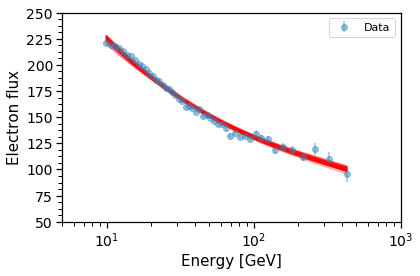

In [41]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for (Cp, gammap, Ce, gammae, Cs, gammas, Esi, g, h, i, j) in a.get_equal_weighted_posterior()[::100,:-1]:
        plt.plot(e_data['Ener'], (e_data['Ener']**3)*electrons(Ce, gammae, Cs, gammas, Esi),color='red',alpha=0.3)

plt.errorbar(e_data['Ener'], (e_data['Ener']**3)*e_data['VALUE'], yerr=(e_data['Ener']**3)*e_data['ERR_STATma'],color='#3288bd',label='Data', fmt='o',alpha=0.5)


ax.legend()
ax.legend(loc='best')
ax.legend(fontsize=9)
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_ylim((50, 250))
ax.set_xlim(5, 1e3)
ax.minorticks_on()
ax.legend(loc='best')
ax.set_xlabel('Energy [GeV]',fontsize=15)
ax.set_ylabel('Electron flux',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(datafile + '_1_electron_flux_ML_fit_all.png')




## PLOT POSITRON FRACTION FROM FIT TO ELECTRONS AND POSITRONS

<Container object of 3 artists>

(0, 0.2)

(5, 1000.0)

(array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]),
 <a list of 6 Text xticklabel objects>)

(array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ]),
 <a list of 9 Text yticklabel objects>)

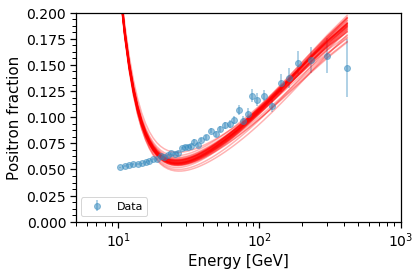

In [44]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#plt.plot(ep_data['Ener'], fraction(Ce_true,gammae_true,Cp_true,gammap_true,Cs_true,gammas_true,Esi_true),color='purple',label='model', alpha=0.7)
for (Cp, gammap, Ce, gammae, Cs, gammas, Esi, g, h, i, j) in a.get_equal_weighted_posterior()[::100,:-1]:
           plt.plot(ep_data['Ener'], fraction(Cp,gammap,Ce,gammae,Cs,gammas,Esi),color='red', alpha=0.3)

plt.errorbar(ep_data['Ener'], ep_data['VALUE'], yerr=ep_data['ERR_STATma'],color='#3288bd',label='Data', fmt='o',alpha=0.5)


ax.legend()
ax.legend(loc='best')
ax.legend(fontsize=9)
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_ylim((0, 2e-1))
ax.set_xlim(5, 1e3)
ax.minorticks_on()
ax.legend(loc='best')
ax.set_xlabel('Energy [GeV]',fontsize=15)
ax.set_ylabel('Positron fraction',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(datafile + '_1_ep_fraction_all.png')

## PLOT POSITRON+ELECTRON FROM FIT TO EVERYTHING

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

(0, 250)

(5, 10000.0)

(array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05]),
 <a list of 7 Text xticklabel objects>)

(array([  0.,  50., 100., 150., 200., 250.]),
 <a list of 6 Text yticklabel objects>)

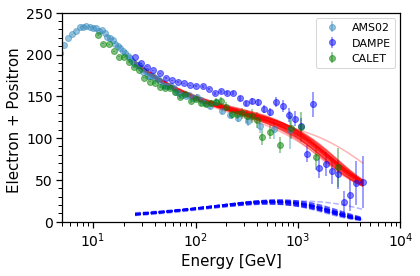

In [45]:

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for (Cp, gammap, Ce, gammae, Cs, gammas, Esi, g, h, i, j) in a.get_equal_weighted_posterior()[::100,:-1]:
           plt.plot(epp_dampe_data['Ener'], (epp_dampe_data['Ener']**3)*suma(Cp,gammap,Ce,gammae,Cs,gammas,Esi),color='red', alpha=0.3)
           plt.plot(epp_dampe_data['Ener'], (epp_dampe_data['Ener']**3)*sour(Cs, gammas, Esi,epp_dampe_data['Ener']),color='blue',ls='--', alpha=0.3)


#plt.plot(e_data['Ener'], (e_data['Ener']**3)*electrons(ml_Ce,ml_gammae,ml_Cp,ml_gammap,ml_Cs,ml_gammas,ml_Esi),color='black',label='model fitted')
#plt.plot(e_data['Ener'], (e_data['Ener']**3)*sour(ml_Cs, ml_gammas, ml_Esi,e_data['Ener']),color='red',label='source fitted')
plt.errorbar(epp_AMS02_data['Ener'], (epp_AMS02_data['Ener']**3)*epp_AMS02_data['VALUE'], yerr=(epp_AMS02_data['Ener']**3)*epp_AMS02_data['ERR_STATma'],color='#3288bd',label='AMS02', fmt='o',alpha=0.5)
plt.errorbar(epp_dampe_data['Ener'], (epp_dampe_data['Ener']**3)*epp_dampe_data['VALUE'], yerr=(epp_dampe_data['Ener']**3)*epp_dampe_data['ERR_STATma'],color='blue',label='DAMPE', fmt='o',alpha=0.5)
plt.errorbar(epp_CALET_data['Ener'], (epp_CALET_data['Ener']**3)*epp_CALET_data['VALUE'], yerr=(epp_CALET_data['Ener']**3)*epp_CALET_data['ERR_STATma'],color='green',label='CALET', fmt='o',alpha=0.5)
#plt.errorbar(p_data['Ener'], (p_data['Ener']**3)*(p_data['VALUE']), yerr=(p_data['Ener']**3)*p_data['ERR_STATma'],color='red',label='Positron AMS02', fmt='s',alpha=0.5)
#plt.errorbar(e_data['Ener'], (e_data['Ener']**3)*e_data['VALUE'], yerr=(e_data['Ener']**3)*e_data['ERR_STATma'],color='yellow',label='Electron AMS02', fmt='^',alpha=0.5)


ax.legend()
ax.legend(loc='best')
ax.legend(fontsize=9)
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_ylim((0, 250))
ax.set_xlim(5, 1e4)
ax.minorticks_on()
ax.legend(loc='best')
ax.set_xlabel('Energy [GeV]',fontsize=15)
ax.set_ylabel('Electron + Positron ',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(datafile + '_1_electron_and_positron_ML_fit_all_multinest.pdf')

